In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load import load_df
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

In [90]:
df = load_df()

In [91]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


# Análise de Clusterização de Dados Socioeconômicos de Países

Este trabalho analisa dados socioeconômicos e de saúde de países para identificar padrões e agrupamentos entre nações com características semelhantes. Os dados foram obtidos do Kaggle e contêm informações sobre mortalidade infantil, expectativa de vida, renda per capita, PIB per capita, investimento em saúde, taxa de fertilidade, inflação, exportações e importações.

Utilizando técnicas de clusterização não supervisionada, buscamos identificar grupos de países com perfis semelhantes e comparar diferentes abordagens algorítmicas para esse tipo de análise.

## Parte 2: Escolha de base de dados

### Carregamento e exploração inicial

### Quantos países existem no dataset?

O dataset contém **167 países**. Podemos verificar isso através da contagem de linhas e também pela visualização das primeiras entradas.

### Faixa dinâmica das variáveis e análise dos dados

Analisando os tipos de dados e estatísticas descritivas, observamos que todas as variáveis numéricas estão em formatos adequados e não há valores nulos. Isso elimina a necessidade de tratamento de dados faltantes.

No entanto, um ponto crítico identificado é a diferença significativa nas escalas das variáveis. O PIB per capita pode chegar a 105.000, enquanto a inflação varia em uma escala muito menor. Essa discrepância pode ser problemática para algoritmos de clusterização baseados em distância, pois variáveis com valores maiores dominariam o cálculo de similaridade.

A visualização através de boxplots antes e depois da padronização mostra claramente esse problema. Antes da normalização, as variáveis têm escalas completamente diferentes. Após aplicar o StandardScaler, todas ficam centralizadas em torno de zero com desvio padrão unitário, garantindo que todas as variáveis contribuam de forma equilibrada no cálculo das distâncias.

### Relações entre variáveis numéricas

Com o pairplot e a matriz de correlação, foi possível identificar relações relevantes entre as variáveis. Essas observações iniciais ajudam a levantar hipóteses que podem se confirmar na clusterização.

Foi observada uma correlação negativa forte entre a mortalidade infantil e outras variáveis como expectativa de vida, renda per capita, PIB per capita e investimento em saúde. Em outras palavras, países com mortalidade infantil mais alta tendem a ter renda mais baixa, menor expectativa de vida e menos recursos destinados à saúde.

Por outro lado, o PIB per capita mostrou correlação positiva com renda, expectativa de vida e saúde. Países com maior PIB per capita geralmente apresentam indicadores sociais e econômicos mais elevados.

Algumas variáveis, como inflação, taxa de fertilidade, exportações e importações, apresentaram correlações fracas ou nulas com as demais. Apesar disso, elas ainda podem desempenhar um papel importante para diferenciar países em faixas específicas dentro dos agrupamentos.

In [92]:
df.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

In [93]:
desc = df.describe(include='all').T
desc['null_count'] = df.isna().sum()

print(desc.head(100))

            count unique          top freq          mean           std     min     25%     50%      75%       max  null_count
country       167    167  Afghanistan    1           NaN           NaN     NaN     NaN     NaN      NaN       NaN           0
child_mort  167.0    NaN          NaN  NaN      38.27006     40.328931     2.6    8.25    19.3     62.1     208.0           0
exports     167.0    NaN          NaN  NaN     41.108976      27.41201   0.109    23.8    35.0    51.35     200.0           0
health      167.0    NaN          NaN  NaN      6.815689      2.746837    1.81    4.92    6.32      8.6      17.9           0
imports     167.0    NaN          NaN  NaN     46.890215     24.209589  0.0659    30.2    43.3    58.75     174.0           0
income      167.0    NaN          NaN  NaN  17144.688623  19278.067698   609.0  3355.0  9960.0  22800.0  125000.0           0
inflation   167.0    NaN          NaN  NaN      7.781832     10.570704   -4.21    1.81    5.39    10.75     104.0     

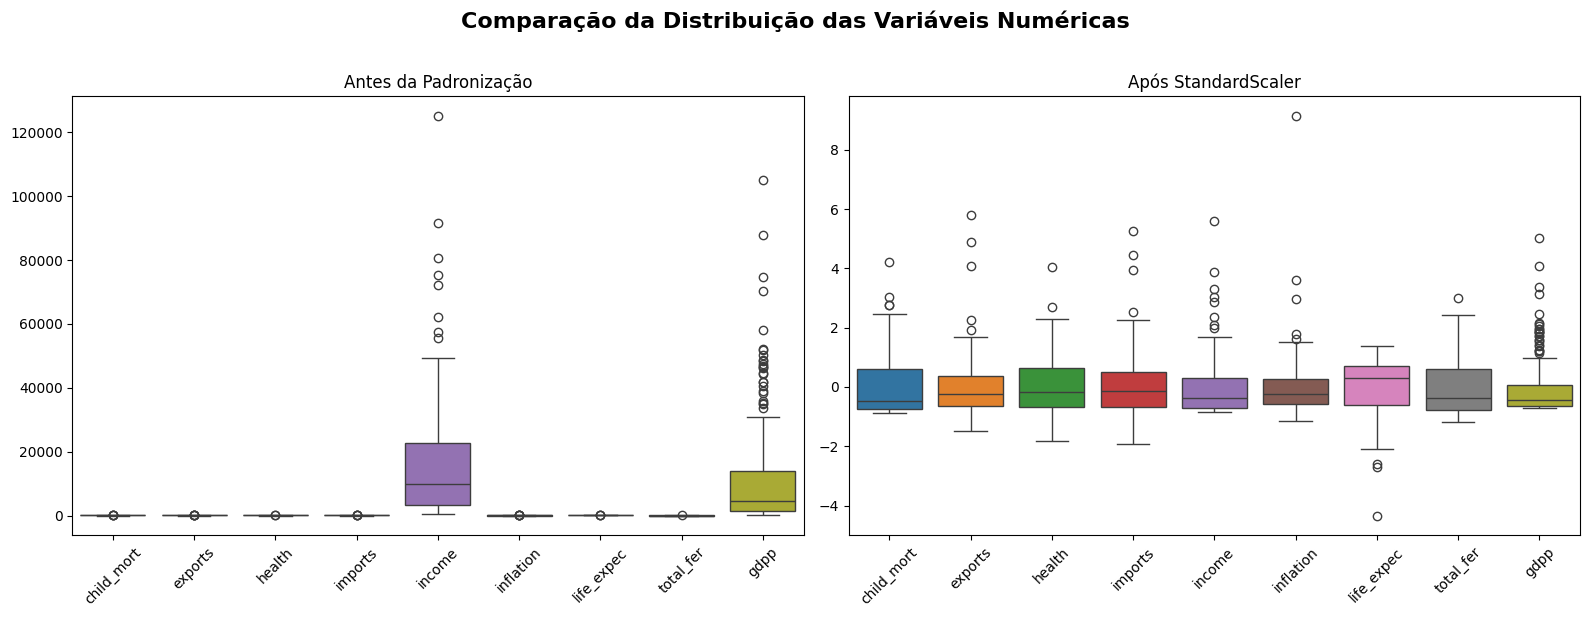

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
df_scaled_standard = df.copy()
df_scaled_standard[numeric_cols] = scaler.fit_transform(df[numeric_cols])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle("Comparação da Distribuição das Variáveis Numéricas", fontsize=16, fontweight='bold', y=1.02)

sns.boxplot(data=df[numeric_cols], ax=axes[0])
axes[0].set_title("Antes da Padronização", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df_scaled_standard[numeric_cols], ax=axes[1])
axes[1].set_title("Após StandardScaler", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

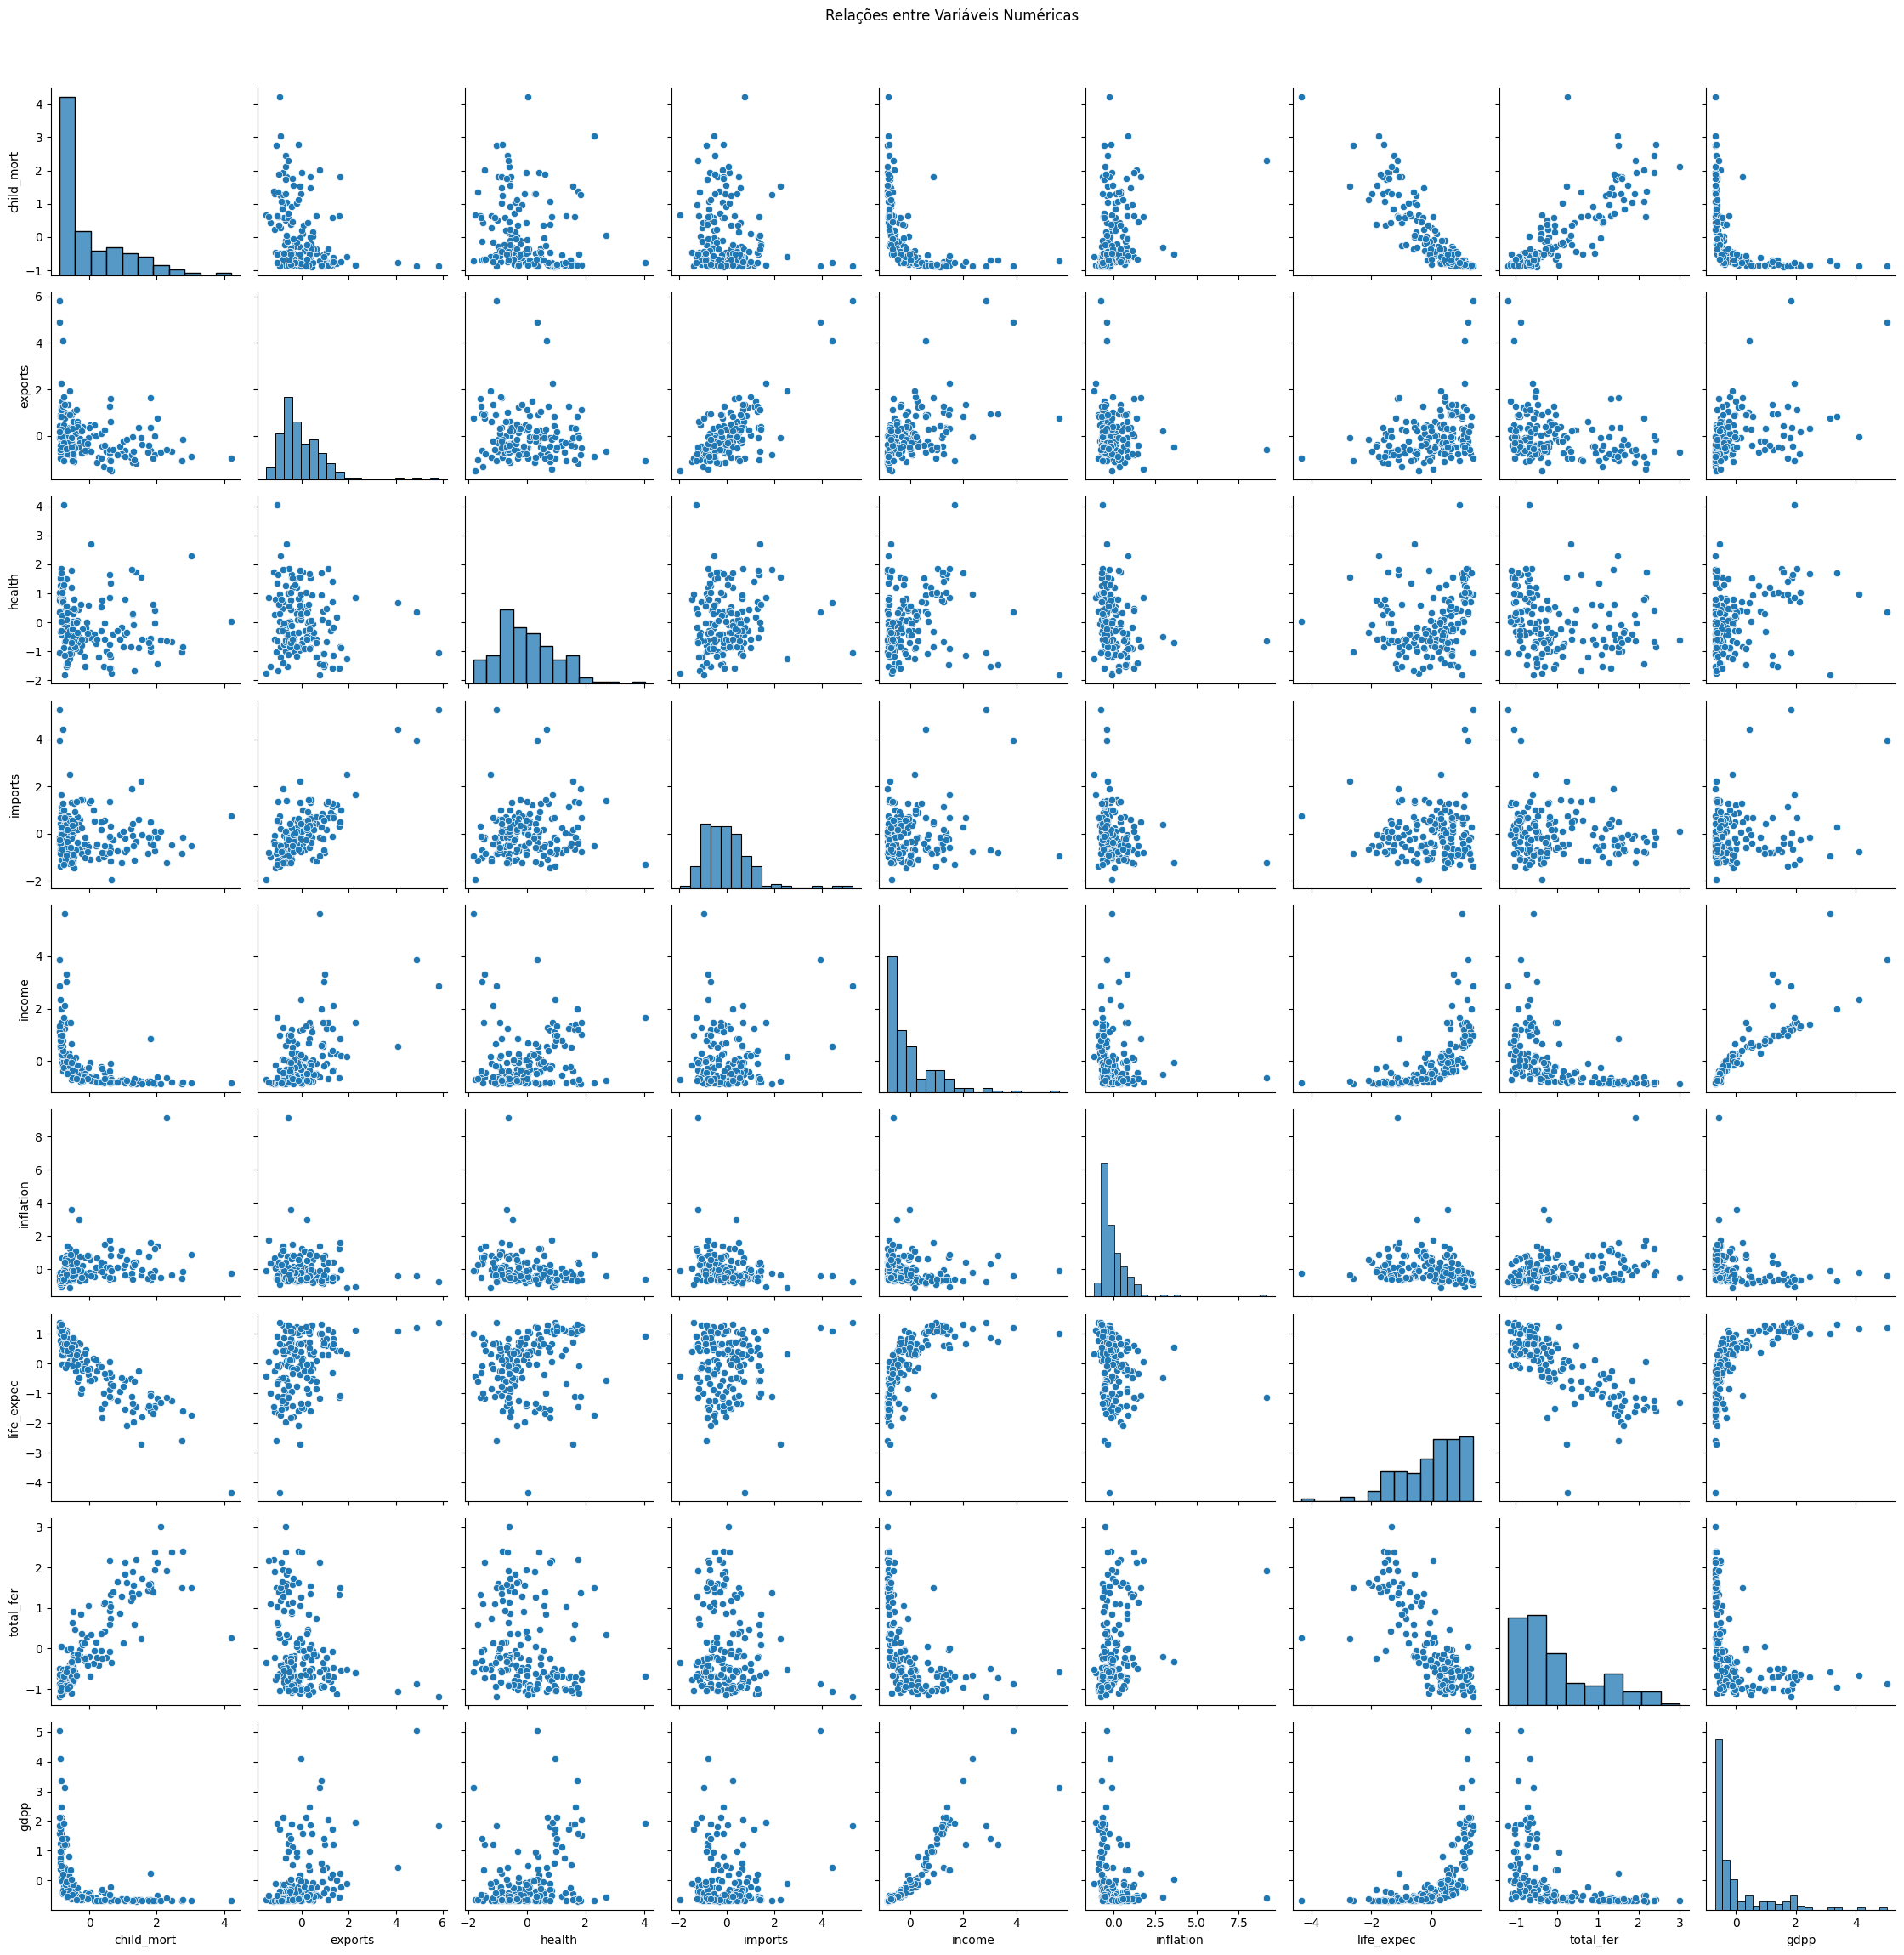

In [11]:
sns.pairplot(df_scaled_standard[numeric_cols])
plt.suptitle("Relações entre Variáveis Numéricas", y=1.02)
plt.tight_layout()

plt.show()


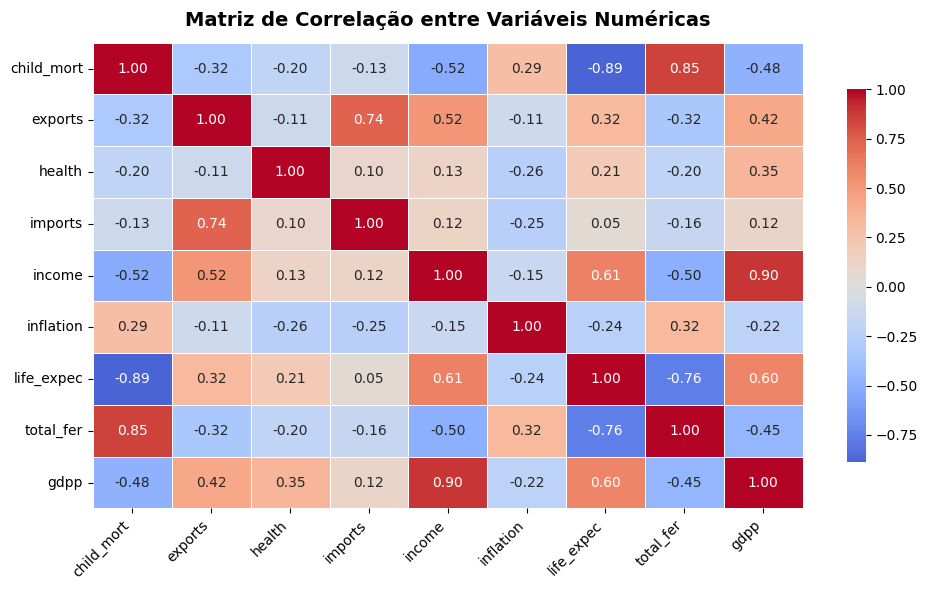

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df_scaled_standard.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr,
    annot=True,              
    fmt=".2f",               
    cmap="coolwarm",         
    center=0,                
    linewidths=0.5,          
    cbar_kws={'shrink': 0.8} 
)

plt.title("Matriz de Correlação entre Variáveis Numéricas", fontsize=14, fontweight='bold', pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Parte 3: Clusterização

### Agrupamento dos países em 3 grupos

Aplicamos dois algoritmos de clusterização para agrupar os 167 países em 3 grupos distintos: K-Médias e Clusterização Hierárquica.

#### K-Médias

O algoritmo K-Médias foi aplicado com k=3 clusters. Os resultados mostram a distribuição dos países entre os três grupos.

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df_scaled_standard[numeric_cols]

kmeans_scaled = KMeans(n_clusters=3, random_state=42)
df_scaled_standard['cluster_scaled'] = kmeans_scaled.fit_predict(X)

print(df_scaled_standard)

                 country  child_mort   exports    health   imports    income  inflation  life_expec  total_fer      gdpp  cluster_scaled
0            Afghanistan    1.291532 -1.138280  0.279088 -0.082455 -0.808245   0.157336   -1.619092   1.902882 -0.679180               2
1                Albania   -0.538949 -0.479658 -0.097016  0.070837 -0.375369  -0.312347    0.647866  -0.859973 -0.485623               0
2                Algeria   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   0.789274    0.670423  -0.038404 -0.465376               0
3                 Angola    2.007808  0.775381 -1.448071 -0.165315 -0.585043   1.387054   -1.179234   2.128151 -0.516268               2
4    Antigua and Barbuda   -0.695634  0.160668 -0.286894  0.497568  0.101732  -0.601749    0.704258  -0.541946 -0.041817               0
..                   ...         ...       ...       ...       ...       ...        ...         ...        ...       ...             ...
162              Vanuatu   -0.225578  0.2

In [97]:
for i in sorted(df_scaled_standard['cluster_scaled'].unique()):
    print(f"\nCluster {i}:")
    display(df_scaled_standard[df_scaled_standard['cluster_scaled'] == i][['country']])



Cluster 0:


,country
1,Albania
2,Algeria
4,Antigua and Barbuda
5,Argentina
6,Armenia
...,...
160,Uruguay
161,Uzbekistan
162,Vanuatu
163,Venezuela



Cluster 1:


,country
7,Australia
8,Austria
11,Bahrain
15,Belgium
23,Brunei
29,Canada
42,Cyprus
43,Czech Republic
44,Denmark
53,Finland



Cluster 2:


,country
0,Afghanistan
3,Angola
17,Benin
25,Burkina Faso
26,Burundi
28,Cameroon
31,Central African Republic
32,Chad
36,Comoros
37,"Congo, Dem. Rep."


In [98]:
df_scaled_standard['cluster_scaled'].value_counts().sort_index()


cluster_scaled
0    86
1    36
2    45
Name: count, dtype: int64

**País que melhor representa cada agrupamento:**

Para identificar o país mais representativo de cada cluster, calculamos a distância de cada país ao centróide de seu grupo. O país com menor distância ao centróide é considerado o mais representativo.

Cluster 0: Albânia. Este país apresenta indicadores próximos da média do grupo, com níveis medianos de renda, saúde e expectativa de vida. Ela apresenta níveis medianos de renda, saúde e expectativa de vida, com taxas de mortalidade infantil e fertilidade um pouco abaixo da média. A Albânia representa bem países que estão em estágio intermediário de desenvolvimento, sem extremos em nenhuma direção, com relativa estabilidade mas ainda distante dos níveis observados em países mais desenvolvidos.

Cluster 1: Austrália. Com alto investimento em saúde, renda elevada, expectativa de vida superior e indicadores demográficos estáveis, a Austrália exemplifica perfeitamente o perfil de desenvolvimento avançado deste cluster. Esse país exemplifica o perfil de desenvolvimento avançado: alto investimento em saúde, renda elevada, expectativa de vida superior à média e indicadores demográficos estáveis.

Cluster 2: Afeganistão. Apresenta valores elevados de mortalidade infantil e fertilidade, baixa expectativa de vida e renda per capita reduzida. O perfil reflete os desafios estruturais compartilhados pelos países deste grupo, como instabilidade política, dificuldade de acesso a serviços essenciais e fragilidade econômica. É o país mais representativo do grupo com os indicadores mais críticos da amostra.

#### Clusterização Hierárquica

### Interpretação dos clusters do K-Médias

A clusterização dos países resultou em três grupos com perfis distintos. A análise dos centróides dos clusters permite identificar padrões comuns entre os países de cada grupo, revelando como os países se agrupam com base em suas condições sociais, econômicas e de saúde.

**Distribuição das dimensões em cada grupo:**

O Cluster 1 concentra 36 países e apresenta valores elevados de expectativa de vida, renda per capita e PIB per capita. A mortalidade infantil é baixa, assim como a taxa de fertilidade. A inflação está controlada e os investimentos em saúde estão acima da média. Esse cluster representa países com alto desenvolvimento socioeconômico e estabilidade. As médias padronizadas apontam para alta expectativa de vida, baixa mortalidade infantil, alta renda e PIB per capita, além de baixa taxa de fertilidade e inflação controlada.

O Cluster 0 é o maior grupo, com 86 países. Os indicadores estão próximos da média global, sem grandes desvios para cima ou para baixo. Não há grandes desvios em nenhuma variável, o que indica um perfil moderado. Os países deste grupo apresentam equilíbrio relativo, sem extrema vulnerabilidade nem alto desenvolvimento. A expectativa de vida está ligeiramente acima da média, enquanto a renda e o PIB ficam um pouco abaixo. A mortalidade infantil é moderada, e a fertilidade também se mantém em níveis intermediários. São países em estágio intermediário, que podem progredir ou regredir dependendo do contexto político e econômico.

O Cluster 2 reúne 45 países com os indicadores mais críticos. A mortalidade infantil é alta, a expectativa de vida é baixa, e tanto a renda quanto o PIB per capita são reduzidos. A taxa de fertilidade é elevada, e a inflação tende a ser maior. Os investimentos em saúde são inferiores. Esses fatores em conjunto apontam para uma condição de maior vulnerabilidade econômica e social.

In [99]:
cluster_means = df_scaled_standard.groupby('cluster_scaled').mean(numeric_only=True)
display(cluster_means)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_scaled,,,,,,,,,
0,-0.393282,-0.030584,-0.206179,0.019562,-0.250930,-0.005783,0.226762,-0.402579,-0.355832
1,-0.827449,0.645080,0.727411,0.190639,1.484243,-0.484921,1.079579,-0.791877,1.615995
2,1.413564,-0.457615,-0.187898,-0.189897,-0.707839,0.398989,-1.297031,1.402874,-0.612761


In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

centroids = df_scaled_standard.groupby('cluster_scaled')[numeric_cols].mean()

for cluster_id in centroids.index:
    cluster_data = df_scaled_standard[df_scaled_standard['cluster_scaled'] == cluster_id]
    centroid = centroids.loc[cluster_id].values.reshape(1, -1)
    closest_idx, _ = pairwise_distances_argmin_min(cluster_data[numeric_cols], centroid)
    country_name = cluster_data.iloc[closest_idx[0]]['country']
    print(f"Cluster {cluster_id}: país mais representativo → {country_name}")

In [ ]:
filtered = df_scaled_standard[df_scaled_standard['country'].isin(['Albania', 'Australia', 'Afghanistan'])]
display(filtered)

**Dendrograma e interpretação:**

O dendrograma mostra o processo de agrupamento hierárquico usando o método Ward, que busca minimizar a variância dentro de cada grupo a cada nova junção de elementos. Cada país aparece na base do gráfico, e as linhas mostram como eles foram sendo unidos em grupos maiores. A altura das conexões indica a distância entre os grupos no momento da fusão: quanto menor a altura, maior a similaridade entre os elementos agrupados.

Foi definido um corte na altura aproximada de 20 unidades, resultando em 3 clusters principais (linha vermelha tracejada). Países unidos abaixo dessa linha têm maior semelhança entre si, enquanto os que foram unidos acima estão mais distantes em termos de características.

À esquerda do dendrograma aparecem países como Luxemburgo, Suíça, Singapura, Noruega e Suécia. Esses países foram agrupados com distâncias pequenas, indicando forte similaridade nos indicadores socioeconômicos. Representam nações com padrões socioeconômicos bastante alinhados. A formação precoce desse cluster sugere uma forte coesão entre seus membros.

No centro, observamos países como Nigéria, Angola, Haiti e Moçambique. Esses países também foram agrupados com proximidade entre si, indicando similaridade interna, mas com distância considerável em relação ao primeiro grupo. As diferenças com os demais clusters sugerem perfis socioeconômicos distintos, caracterizando um padrão específico de condições.

À direita está um grupo mais abrangente e heterogêneo. Representa um grupo mais abrangente, com maior heterogeneidade. Embora contenha subgrupos bem definidos internamente, foi unido aos outros clusters apenas em estágios finais do dendrograma, com distâncias elevadas, indicando menor similaridade geral com os demais países do conjunto analisado.

A média padronizada dos indicadores em cada cluster permite observar como os grupos se diferenciam. O Cluster 1 apresenta valores elevados de renda, PIB per capita, expectativa de vida e investimentos em saúde, com baixa mortalidade infantil e taxa de fertilidade, refletindo países de alto desenvolvimento. O Cluster 2 tem mortalidade infantil e fertilidade elevadas, além de baixa expectativa de vida, renda e investimentos em saúde, representando países em situação de maior vulnerabilidade. O Cluster 3 apresenta valores intermediários ou próximos da média global, indicando um perfil misto que reflete países em estágio de desenvolvimento moderado ou em transição.

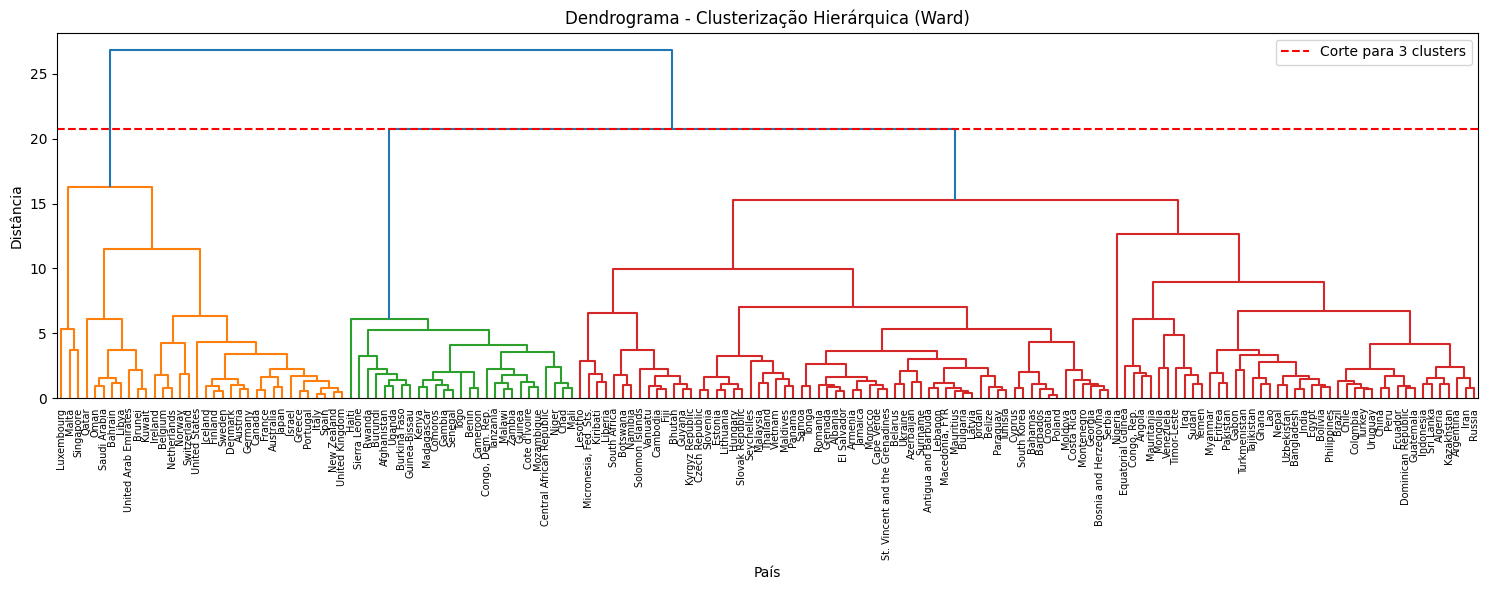


Distribuição dos clusters:
cluster_hier
1     34
2     27
3    106
Name: count, dtype: int64


In [103]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

linked = linkage(df_scaled_standard[numeric_cols], method='ward')

clusters = fcluster(linked, t=3, criterion='maxclust')
df_scaled_standard['cluster_hier'] = clusters

from scipy.cluster.hierarchy import inconsistent
max_d = linked[-2, 2]

plt.figure(figsize=(15, 6))
dendrogram(
    linked,
    labels=df_scaled_standard['country'].values,
    leaf_rotation=90,
    leaf_font_size=7,
    color_threshold=max_d
)
plt.axhline(y=max_d, color='red', linestyle='--', label=f'Corte para 3 clusters')
plt.title('Dendrograma - Clusterização Hierárquica (Ward)')
plt.xlabel('País')
plt.ylabel('Distância')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nDistribuição dos clusters:")
print(df_scaled_standard['cluster_hier'].value_counts().sort_index())

In [111]:
cluster_hier = df_scaled_standard.groupby('cluster_hier').mean(numeric_only=True)
display(cluster_hier)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_scaled,cluster_medoide_custom,cluster_dbscan
cluster_hier,,,,,,,,,,,,
1,-0.803529,0.636662,0.615456,0.083388,1.583930,-0.347882,1.063177,-0.701934,1.652996,0.911765,2.000000,0.588235
2,1.661368,-0.641034,-0.112704,-0.299426,-0.809299,-0.060637,-1.500878,1.646940,-0.672893,2.000000,0.888889,-0.259259
3,-0.165443,-0.040930,-0.168703,0.049522,-0.301911,0.127030,0.041280,-0.194355,-0.358809,0.386792,1.490566,0.462264


### Comparação entre K-Médias e Clusterização Hierárquica

Ambos os métodos identificaram três perfis principais de países, mas com algumas diferenças na composição dos grupos e na forma como agrupam os países.

Nos clusters de países desenvolvidos, o K-Médias formou um grupo com 36 países que possuem os indicadores mais extremos em termos de desenvolvimento. A clusterização hierárquica também identificou um grupo de países desenvolvidos, mas agrupou aqueles que são mais similares entre si, mesmo que alguns não estejam no nível mais extremo. Os valores médios dos indicadores mostram que o cluster hierárquico tem médias ligeiramente superiores ao do K-Médias para esse grupo, pois a hierárquica criou um grupo com países parecidos entre si, mesmo que os números não sejam tão altos quanto os do K-Médias.

Para os países em desenvolvimento, a clusterização hierárquica isolou mais fortemente os países com as condições mais críticas, resultando em médias mais extremas de mortalidade infantil, fertilidade e baixa expectativa de vida. O K-Médias incluiu uma composição um pouco mais heterogênea nesse cluster, podendo ter incluído países em desenvolvimento não só os mais vulneráveis. Ambos os métodos identificaram bem os países com mais desafios, mas a hierárquica criou um grupo mais uniforme de países com situação crítica, enquanto o K-Médias misturou um pouco mais.

No grupo intermediário, o K-Médias formou o maior cluster com 86 países, apresentando indicadores ligeiramente melhores que a média. A hierárquica criou um grupo intermediário mais próximo da média geral, com maior heterogeneidade interna. O grupo do K-Médias tem números um pouco melhores em alguns indicadores, enquanto a hierárquica formou um grupo mais equilibrado, mais próximo da média geral.

A principal diferença conceitual é que o K-Médias busca separar os países por distâncias médias aos centróides, criando perfis bem distintos entre si pela média de cada grupo. Já a clusterização hierárquica agrupa países por semelhança progressiva entre pares, resultando em clusters mais coesos internamente. O K-Médias produz separações mais nítidas baseadas em perfis extremos, enquanto a hierárquica revela estruturas de similaridade gradual, encontrando grupos mais parecidos internamente, o que facilita comparações diretas entre países com características próximas.

In [104]:
print(cluster_means.head())
print(cluster_hier.head())

                child_mort   exports    health   imports    income  inflation  life_expec  total_fer      gdpp
cluster_scaled                                                                                                
0                -0.393282 -0.030584 -0.206179  0.019562 -0.250930  -0.005783    0.226762  -0.402579 -0.355832
1                -0.827449  0.645080  0.727411  0.190639  1.484243  -0.484921    1.079579  -0.791877  1.615995
2                 1.413564 -0.457615 -0.187898 -0.189897 -0.707839   0.398989   -1.297031   1.402874 -0.612761
              child_mort   exports    health   imports    income  inflation  life_expec  total_fer      gdpp  cluster_scaled
cluster_hier                                                                                                                
1              -0.803529  0.636662  0.615456  0.083388  1.583930  -0.347882    1.063177  -0.701934  1.652996        0.911765
2               1.661368 -0.641034 -0.112704 -0.299426 -0.809299  -0.0

## Parte 4: Escolha de algoritmos

### Etapas do algoritmo de K-médias até sua convergência

1. Definir o número de clusters k que se deseja formar

2. Inicializar os centróides: selecionar aleatoriamente k pontos do conjunto de dados como centróides iniciais

3. Atribuir cada ponto ao centróide mais próximo: para cada país, calcular a distância até todos os centróides e atribuí-lo ao cluster do centróide mais próximo

4. Atualizar os centróides: para cada cluster, calcular a média de todos os pontos atribuídos a ele, que passa a ser o novo centróide

5. Repetir os passos 3 e 4 até a convergência: continuar reatribuindo pontos e recalculando centróides até que as mudanças sejam mínimas

6. Verificar convergência: o algoritmo para quando os centróides não se alteram mais significativamente, quando as atribuições dos pontos não mudam mais, ou quando um número máximo de iterações é atingido

O resultado final divide os dados em k grupos onde cada país está no cluster cujo centróide está mais próximo dele. O algoritmo minimiza a soma das distâncias quadradas dentro de cada cluster.

### Algoritmo com medóide (dado mais próximo ao baricentro)

In [112]:
import numpy as np
from sklearn.metrics import pairwise_distances

X = df_scaled_standard[numeric_cols].values

K = 3
max_iter = 100
np.random.seed(42)

initial_idxs = np.random.choice(len(X), K, replace=False)
medoids = X[initial_idxs]

for i in range(max_iter):
    distances = pairwise_distances(X, medoids)
    labels = np.argmin(distances, axis=1)

    new_medoids = []

    for k in range(K):
        cluster_points = X[labels == k]
        if len(cluster_points) == 0:
            continue

        centroid = cluster_points.mean(axis=0)

        distances_to_centroid = pairwise_distances(cluster_points, centroid.reshape(1, -1))
        closest_idx = np.argmin(distances_to_centroid)
        new_medoids.append(cluster_points[closest_idx])

    new_medoids = np.array(new_medoids)

    if np.allclose(medoids, new_medoids):
        break

    medoids = new_medoids.copy()

df_scaled_standard['cluster_medoide_custom'] = labels

In [113]:
cluster_medoide = df_scaled_standard.groupby('cluster_medoide_custom').mean(numeric_only=True)

print(cluster_means)
print(cluster_hier)
print(cluster_medoide)

                child_mort   exports    health   imports    income  inflation  life_expec  total_fer      gdpp
cluster_scaled                                                                                                
0                -0.393282 -0.030584 -0.206179  0.019562 -0.250930  -0.005783    0.226762  -0.402579 -0.355832
1                -0.827449  0.645080  0.727411  0.190639  1.484243  -0.484921    1.079579  -0.791877  1.615995
2                 1.413564 -0.457615 -0.187898 -0.189897 -0.707839   0.398989   -1.297031   1.402874 -0.612761
              child_mort   exports    health   imports    income  inflation  life_expec  total_fer      gdpp  cluster_scaled  cluster_medoide_custom  cluster_dbscan
cluster_hier                                                                                                                                                        
1              -0.803529  0.636662  0.615456  0.083388  1.583930  -0.347882    1.063177  -0.701934  1.652996       

A implementação acima garante que o cluster seja sempre representado por um dado real do conjunto (medóide), ao invés de um ponto abstrato (centróide). A cada iteração, após calcular o baricentro do cluster (a média), o algoritmo identifica o país mais próximo desse baricentro e o utiliza como novo medóide. Esse medóide é sempre um ponto real do dataset.

Os países medoides identificados foram Kiribati, Gana e Coreia do Sul. Comparando as médias dos clusters, observa-se que os valores do algoritmo com medóides são menos extremos que os do K-médias tradicional. Isso ocorre porque o medóide é um ponto real do dataset, enquanto o centróide pode ser puxado por valores extremos sem necessariamente representar bem nenhum país específico. Os medoides são países reais do dataset, o que torna os resultados mais facilmente interpretáveis e menos sensíveis a outliers, pois evita que outliers virem centro do grupo ao escolher apenas pontos reais.

| Aspecto                            | K-Means                       | Hierárquico (Ward)                   | K-Medoids (custom)              |
| ---------------------------------- | ----------------------------- | ------------------------------------ | ------------------------------- |
| Grupos extremos                    | Sim                           | Sim, mas menos extremos              | Não                             |
| Foco                               | Separar por distâncias médias | Agrupar por similaridade entre pares | Representatividade real         |
| Valores de saída                   | Centrados em desvios padrão   | Centrados e agrupados por distância  | Próximos à média geral          |
| Robustez a outliers                | Baixa                         | Média                                | Alta                            |
| Medida central                     | Centróide (média)             | Similaridade entre pares             | Medóide (ponto real)            |
| Melhor para interpretar realidades | Moderado                      | Boa separação por coesão             | Boa representatividade de casos |

In [114]:
import pandas as pd
import numpy as np

for i, medoid_vector in enumerate(medoids):
    distances = np.linalg.norm(df_scaled_standard[numeric_cols].values - medoid_vector, axis=1)
    
    closest_idx = np.argmin(distances)
    
    country_name = df_scaled_standard.iloc[closest_idx]['country']
    print(f"Cluster {i}: país medoide → {country_name}")

Cluster 0: país medoide → Kiribati
Cluster 1: país medoide → Ghana
Cluster 2: país medoide → South Korea


### Sensibilidade do K-médias a outliers

O K-médias é sensível a outliers porque calcula o centróide de cada cluster como a média aritmética das coordenadas de todos os pontos do cluster. Quando há outliers (pontos muito distantes da maioria), esses valores extremos puxam a média para si, deslocando o centróide para longe da massa principal de dados.

Imagine um cluster com países de PIB 10, 12, 13 e 70. A média (centróide) será aproximadamente 26, fortemente influenciada pelo valor 70. O resultado é que o centróide não representa bem nenhum dos países do grupo. Os três primeiros países estão longe do centróide que deveria representá-los, e o país com PIB 70 pode estar distorcendo toda a formação do cluster.

Esse efeito se propaga por todas as variáveis do dataset. Um único país com características extremas em várias dimensões pode distorcer significativamente o posicionamento do centróide, afetando não apenas a interpretação do cluster, mas também a atribuição de outros países a esse grupo nas próximas iterações.

### Por que o DBSCAN é mais robusto à presença de outliers?

O DBSCAN é mais robusto a outliers porque não assume que todos os pontos devem pertencer a um cluster. O algoritmo forma clusters baseado em densidade: um ponto precisa ter um número mínimo de vizinhos dentro de um raio específico para fazer parte de um cluster denso. Pontos isolados são classificados diretamente como ruído, e a formação dos clusters depende da densidade local, não da distância a um centro artificial.

O funcionamento é o seguinte: o algoritmo escolhe um ponto e verifica se ele possui o número mínimo de vizinhos (min_samples) dentro de um raio (eps). Se sim, um novo cluster é formado e cresce à medida que encontra pontos densamente conectados. Pontos que não atendem a esse critério são marcados como ruído e não entram em nenhum grupo.

A principal diferença para o K-médias é que o DBSCAN não força outliers a pertencerem a um grupo. Pontos isolados que estão distantes da densidade central de qualquer grupo são simplesmente classificados como ruído e ignorados, pois não têm vizinhança suficiente. Isso evita que valores extremos distorçam os clusters formados.

Imagine um mapa com várias cidades. A maioria das cidades está em regiões metropolitanas densas. Algumas estão isoladas no meio do nada. O K-Médias vai forçar cada cidade a pertencer a uma região metropolitana, mesmo que esteja sozinha no deserto. O DBSCAN vai simplesmente dizer que essa cidade está muito longe de qualquer outra e é um ponto fora do padrão.

Enquanto o K-médias obrigaria cada país a pertencer a um dos k clusters (mesmo que não se encaixe bem em nenhum), o DBSCAN reconhece que alguns países podem ter perfis únicos que não se encaixam em nenhum padrão principal. Entre os métodos comparados, o DBSCAN é o único que trata outliers como parte natural do processo, reconhecendo que nem todo ponto precisa pertencer a um cluster. Essa flexibilidade torna o algoritmo mais adequado para datasets com ruído, formas irregulares e agrupamentos com densidades variadas.

### Tabela Comparativa: Robustez a Outliers

| Algoritmo      | Como define o centro            | Lida com outliers? | Como lida?                                                              |
|----------------|----------------------------------|---------------------|-------------------------------------------------------------------------|
| K-Means     | Média dos pontos (centróide)     | Não               | Outliers puxam o centróide e distorcem o formato do cluster             |
| Hierárquico | Similaridade entre pares         | Parcialmente      | Pode ser afetado por outliers dependendo do método de ligação usado     |
| K-Medoids   | Ponto real mais central (medoide) | Sim               | Evita que outliers virem centro do grupo, pois escolhe pontos reais     |
| DBSCAN      | Núcleos densos (sem centróide)   | Sim               | Classifica outliers como ruído, sem obrigá-los a fazer parte de clusters |

In [108]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [109]:
X = df_scaled_standard[numeric_cols].values
dbscan = DBSCAN(eps=1.2, min_samples=4)
labels = dbscan.fit_predict(X)

df_scaled_standard['cluster_dbscan'] = labels

In [74]:
print(df_scaled_standard)

                 country  child_mort   exports    health   imports    income  inflation  life_expec  total_fer      gdpp  cluster_scaled  cluster_hier  cluster_medoide_custom  cluster_dbscan
0            Afghanistan    1.291532 -1.138280  0.279088 -0.082455 -0.808245   0.157336   -1.619092   1.902882 -0.679180               2             2                       1               0
1                Albania   -0.538949 -0.479658 -0.097016  0.070837 -0.375369  -0.312347    0.647866  -0.859973 -0.485623               0             3                       2               1
2                Algeria   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   0.789274    0.670423  -0.038404 -0.465376               0             3                       1               1
3                 Angola    2.007808  0.775381 -1.448071 -0.165315 -0.585043   1.387054   -1.179234   2.128151 -0.516268               2             3                       1              -1
4    Antigua and Barbuda   -0.695634  0.16066

In [115]:
cluster_dbscan = df_scaled_standard.groupby('cluster_dbscan').mean(numeric_only=True)

print("K-Means:")
print(cluster_means)
print("\nHierárquico:")
print(cluster_hier)
print("\nK-Medoids:")
print(cluster_medoide)
print("\nDBSCAN:")
print(cluster_dbscan)

K-Means:
                child_mort   exports    health   imports    income  inflation  life_expec  total_fer      gdpp
cluster_scaled                                                                                                
0                -0.393282 -0.030584 -0.206179  0.019562 -0.250930  -0.005783    0.226762  -0.402579 -0.355832
1                -0.827449  0.645080  0.727411  0.190639  1.484243  -0.484921    1.079579  -0.791877  1.615995
2                 1.413564 -0.457615 -0.187898 -0.189897 -0.707839   0.398989   -1.297031   1.402874 -0.612761

Hierárquico:
              child_mort   exports    health   imports    income  inflation  life_expec  total_fer      gdpp  cluster_scaled  cluster_medoide_custom  cluster_dbscan
cluster_hier                                                                                                                                                        
1              -0.803529  0.636662  0.615456  0.083388  1.583930  -0.347882    1.063177  -0.